In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.manifold import TSNE
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

%load_ext autoreload
%autoreload 2
import steering_vectors

#### Preliminaries

Let's first load the model as usual. 

In [2]:
# Let's load the model 
device = 'cuda:4'
model_name = 'microsoft/Phi-3.5-mini-instruct'

# Load Phi model 
model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    device_map=device, 
    torch_dtype="auto", 
    trust_remote_code=True, 
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Next, we will define a function that applies a chat template to our instructions. 

In [3]:
def tokenize_instructions(tokenizer, instructions):
    return tokenizer.apply_chat_template(
        instructions,
        padding=True,
        truncation=False,
        return_tensors="pt",
        return_dict=True,
        add_generation_prompt=True,
    ).input_ids

And we will load our data. 

In [4]:
styles = [{'A': 'concise', 'B': 'longwinded'}, {'A': 'informal', 'B': 'formal'}, {'A': 'serious', 'B': 'humorous'}, {'A': 'angry', 'B': 'loving'}] 
with open('../data/styles/email_prompts_n=50.json') as f:
    email_data = json.load(f)
with open('../data/styles/email_prompts_n=50_with_concepts_phimodel.json') as f:
    email_data_w_concept = json.load(f)
# print some examples
print(email_data[0])
print(email_data_w_concept['humorous'][0])

Write an email to a colleague requesting a meeting to discuss a new project.


Subject: Let's Brainstorm Some Fun Ideas for Our New Project!

Hey there,

I hope this email finds you in good spirits and ready to embark on a wild ride of creativity! I've been daydreaming about our upcoming project, and I can't help but imagine it as a rollercoaster of innovation and laughter. So, I'm reaching out to propose a meeting where we can exchange our wacky ideas and turn them into something truly extraordinary.

Picture this: We gather around the table, armed with


### Visualisation of the different styles

In [5]:
# collect activations 
layer = 6
acts = {}
def get_activation(name):
    def hook(model, input):
        acts[name] = input[0]
    return hook
h = model.model.layers[layer].register_forward_pre_hook(get_activation(layer))
seq_of_choice = -1
activations = [] 
labels = []
for style in styles: 
    print(style)
    dd_with_c_A = email_data_w_concept[style['A']]
    dd_with_c_B = email_data_w_concept[style['B']]
    for i in range(len(dd_with_c_A)): 
        toks_A = tokenize_instructions(tokenizer, [{"role": "user", "content": dd_with_c_A[i]}])
        with torch.no_grad():
            model(toks_A.to(device))
            activations.append(acts[layer].cpu().float().numpy()[0,seq_of_choice,:])
            labels.append(style['A'])
    for i in range(len(dd_with_c_B)):
        toks_B = tokenize_instructions(tokenizer, [{"role": "user", "content": dd_with_c_B[i]}])
        with torch.no_grad():
            model(toks_B.to(device))
            activations.append(acts[layer].cpu().float().numpy()[0,seq_of_choice,:])
            labels.append(style['B'])
h.remove() 

{'A': 'concise', 'B': 'longwinded'}


You are not running the flash-attention implementation, expect numerical differences.


{'A': 'informal', 'B': 'formal'}
{'A': 'serious', 'B': 'humorous'}
{'A': 'angry', 'B': 'loving'}


In [6]:
# do tsne 
tsne = TSNE(n_components=2, random_state=0)
activations = np.array(activations)
print(activations.shape)
X_2d = tsne.fit_transform(activations) # [n_samples, 2]

(174, 3072)


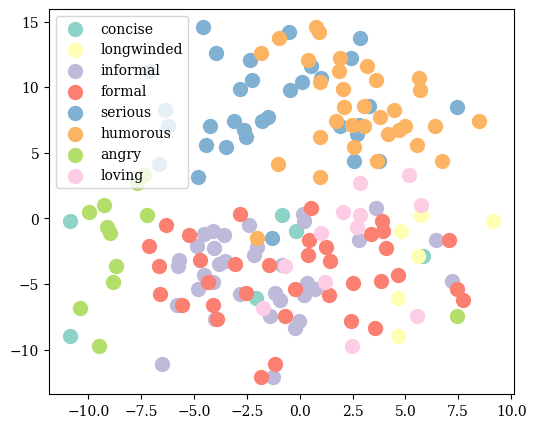

In [7]:
# plot with labels 
colors = plt.cm.Set3(np.linspace(0, 1, 12))  # 'tab10' is a good choice for up to 10 discrete colors
cdict = {styles[0]['A']: colors[0], styles[0]['B']: colors[1], styles[1]['A']: colors[2], styles[1]['B']: colors[3], styles[2]['A']: colors[4], styles[2]['B']: colors[5], styles[3]['A']: colors[6], styles[3]['B']: colors[7]}
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.figure(figsize=(6, 5))
for g in styles:
    ix_A = [ix for ix, l in enumerate(labels) if l == g['A']]
    ix_B = [ix for ix, l in enumerate(labels) if l == g['B']]
    plt.scatter(X_2d[ix_A,0], X_2d[ix_B,1], color = cdict[g['A']], label = g['A'], s = 100)
    plt.scatter(X_2d[ix_B,0], X_2d[ix_B,1], color = cdict[g['B']], label = g['B'], s = 100)
plt.legend()
plt.grid(False)
plt.show()

### Optimise steering vectors for different styles 

Here we optimise the steering vectors using the 'full' optimisation method. 

In [8]:
styleA = styles[0]['A']
styleB = styles[0]['B']
data_A = email_data_w_concept[styleA]
data_B = email_data_w_concept[styleB]
print(len(data_A), len(data_B))

# to optimise the steering vector, we prepend the data with the instruction 
instr = email_data[:len(data_A)]
dd_with_c_A = [[{"role": "user", "content": x}, {"role": "assistant", "content":y}] for (x,y) in zip(instr,data_A)]
dd_with_c_B = [[{"role": "user", "content": x}, {"role": "assistant", "content":y}] for (x,y) in zip(instr,data_B)]
toks_A = tokenize_instructions(tokenizer, dd_with_c_A).to(device)
toks_B = tokenize_instructions(tokenizer, dd_with_c_B).to(device)

# during optimisation, we plot the predicted tokens just to see how things are progressing
sv_optimised = steering_vectors.optimise_steering_vecs(model, toks_A, toks_B, hidden_dim=3072, layer=20, num_epochs=100)

6 6
0 3.0054304599761963
0 2.983832597732544
0 2.9672341346740723
0 2.9492812156677246
0 2.931544303894043
0 2.910517930984497
0 2.8898026943206787
0 2.8756797313690186
0 2.8580124378204346
0 2.8387224674224854
0 2.826636791229248
0 2.806621789932251
0 2.790630340576172
0 2.7731680870056152
0 2.7549757957458496
0 2.7329213619232178
0 2.7130484580993652
0 2.6970276832580566
0 2.6754226684570312
0 2.6577773094177246
0 2.6395390033721924
0 2.6181702613830566
0 2.601374387741089
0 2.5845298767089844
0 2.56186580657959
0 2.5419540405273438
0 2.5208897590637207
0 2.4950976371765137
0 2.473587989807129
0 2.451765537261963
0 2.424241542816162
0 2.403856039047241
0 2.3788444995880127
0 2.3514347076416016
0 2.3281354904174805
0 2.2981600761413574
0 2.27597713470459
0 2.247002124786377
0 2.2161412239074707
0 2.1903114318847656
0 2.1596860885620117
0 2.130026340484619
0 2.088489055633545
0 2.0593490600585938
0 2.0176265239715576
0 1.9748897552490234
0 1.9437017440795898
0 1.940852403640747
0 1.927

In [9]:
# test the steering vector
for it in range(0,5): 
    new_prompt = email_data[it]
    toks_test = tokenize_instructions(tokenizer, [{"role": "user", "content": new_prompt}])
    # steer to B
    generation_intervene, _ = steering_vectors.do_steering(model, toks_test.to(device), sv_optimised.to(device), scale = 1, layer = [20], proj=False, all_toks=False)
    intervene = tokenizer.decode(generation_intervene[0], skip_special_tokens=True)
    print('Steer to {}: '.format(styleB), intervene)
    # steer to A
    generation_intervene, _ = steering_vectors.do_steering(model, toks_test.to(device), sv_optimised.to(device), scale = -1, layer = [20], proj=False, all_toks=False)
    intervene = tokenizer.decode(generation_intervene[0], skip_special_tokens=True)
    print('Steer to {}: '.format(styleA), intervene)


Steer to longwinded:  Write an email to a colleague requesting a meeting to discuss a new project. Subject: Request for Meeting to Discuss Upcoming Project

Dear [Colleague's Name],

I hope this email finds you in the best of spirits and health. I am writing to you today as we have been presented with an exciting opportunity for collaboration that I believe will prove to be a significant venture for both of us.

I have recently been given the opportunity to spearhead a new project that I am deeply passionate about, and I feel that your expertise and insights would be invaluable in its successful execution. The project, which I have come to refer to as [Project Title], holds immense potential and I am convinced that our combined intellects will bring it to
Steer to concise:  Write an email to a colleague requesting a meeting to discuss a new project. Subject: Proposal for Project Meeting

Dear [Colleague's Name],

I hope this email finds you well.

I am writing to request a meeting to d

In [10]:
styleA = styles[1]['A']
styleB = styles[1]['B']
data_A = email_data_w_concept[styleA]
data_B = email_data_w_concept[styleB]
print(len(data_A), len(data_B))

# to optimise the steering vector, we prepend the data with the instruction 
instr = email_data[:len(data_A)]
dd_with_c_A = [[{"role": "user", "content": x}, {"role": "assistant", "content":y}] for (x,y) in zip(instr,data_A)]
dd_with_c_B = [[{"role": "user", "content": x}, {"role": "assistant", "content":y}] for (x,y) in zip(instr,data_B)]
toks_A = tokenize_instructions(tokenizer, dd_with_c_A).to(device)
toks_B = tokenize_instructions(tokenizer, dd_with_c_B).to(device)

# during optimisation, we plot the predicted tokens just to see how things are progressing
sv_optimised = steering_vectors.optimise_steering_vecs(model, toks_A, toks_B, hidden_dim=3072, layer=20, num_epochs=10)

36 36
0 3.2505710124969482
6 3.130340814590454
12 3.1892311573028564
18 3.1976730823516846
24 3.2384400367736816
30 3.211679458618164
0 3.1751811504364014
6 3.076019763946533
12 3.1401078701019287
18 3.1436259746551514
24 3.1852264404296875
30 3.1674282550811768
0 3.1278457641601562
6 3.048583745956421
12 3.103133201599121
18 3.10268497467041
24 3.1425037384033203
30 3.124069929122925
0 3.0828750133514404
6 3.0188310146331787
12 3.06654953956604
18 3.0595269203186035
24 3.099956512451172
30 3.083836555480957
0 3.0406980514526367
6 2.986149311065674
12 3.0263144969940186
18 3.0138351917266846
24 3.0497546195983887
30 3.0465569496154785
0 3.0002288818359375
6 2.9505343437194824
12 2.9921987056732178
18 2.971031427383423
24 2.9982333183288574
30 3.006479263305664
0 2.949340581893921
6 2.908275604248047
12 2.9512593746185303
18 2.921919107437134
24 2.9491944313049316
30 2.960845470428467
0 2.898015022277832
6 2.871713399887085
12 2.9079320430755615
18 2.858944892883301
24 2.885688781738281

In [11]:
# test the steering vector
for it in range(0,5): 
    new_prompt = email_data[it]
    toks_test = tokenize_instructions(tokenizer, [{"role": "user", "content": new_prompt}])
    # steer to B
    generation_intervene, _ = steering_vectors.do_steering(model, toks_test.to(device), sv_optimised.to(device), scale = 1, layer = [20], proj=False, all_toks=False)
    intervene = tokenizer.decode(generation_intervene[0], skip_special_tokens=True)
    print('Steer to {}: '.format(styleB), intervene)
    # steer to A
    generation_intervene, _ = steering_vectors.do_steering(model, toks_test.to(device), sv_optimised.to(device), scale = -1, layer = [20], proj=False, all_toks=False)
    intervene = tokenizer.decode(generation_intervene[0], skip_special_tokens=True)
    print('Steer to {}: '.format(styleA), intervene)


Steer to formal:  Write an email to a colleague requesting a meeting to discuss a new project. Subject: Request for Meeting Regarding New Project Initiative

Dear [Colleague's Name],

I hope this email finds you well.

I am writing to request a meeting to discuss a new project that has recently been introduced to our department. The project, titled "[Project Title]," is of significant importance and I believe it would be beneficial for both of us to discuss its implications, potential challenges, and our roles in its successful execution.

Given your expertise in [specific area relevant to the project], I believe your insights and suggestions would be invaluable to the project. I propose that we arrange a meeting on [proposed date] at [pro
Steer to informal:  Write an email to a colleague requesting a meeting to discuss a new project. Subject: Let's Brainstorm: New Project Discussion & Planning


Hey [Colleague's Name],


Hope you're doing well! I've been brainstorming some ideas for a

In [12]:
styleA = styles[2]['A']
styleB = styles[2]['B']
data_A = email_data_w_concept[styleA]
data_B = email_data_w_concept[styleB]
print(len(data_A), len(data_B))

# to optimise the steering vector, we prepend the data with the instruction 
instr = email_data[:len(data_A)]
dd_with_c_A = [[{"role": "user", "content": x}, {"role": "assistant", "content":y}] for (x,y) in zip(instr,data_A)]
dd_with_c_B = [[{"role": "user", "content": x}, {"role": "assistant", "content":y}] for (x,y) in zip(instr,data_B)]
toks_A = tokenize_instructions(tokenizer, dd_with_c_A).to(device)
toks_B = tokenize_instructions(tokenizer, dd_with_c_B).to(device)

# during optimisation, we plot the predicted tokens just to see how things are progressing
sv_optimised = steering_vectors.optimise_steering_vecs(model, toks_A, toks_B, hidden_dim=3072, layer=20, num_epochs=10)

33 33
0 2.4044241905212402
6 2.55448055267334
12 2.688795804977417
18 2.54298996925354
24 2.623495578765869
30 2.5603487491607666
0 2.3505029678344727
6 2.512098550796509
12 2.53690242767334
18 2.5111076831817627
24 2.592768430709839
30 2.523703098297119
0 2.3070192337036133
6 2.470093250274658
12 2.5084238052368164
18 2.4747140407562256
24 2.5455565452575684
30 2.4823551177978516
0 2.254770278930664
6 2.4160234928131104
12 2.469756841659546
18 2.435481071472168
24 2.4975671768188477
30 2.420787811279297
0 2.189345359802246
6 2.3596441745758057
12 2.429372787475586
18 2.394853115081787
24 2.447803020477295
30 2.3797719478607178
0 2.1308326721191406
6 2.2964351177215576
12 2.400021553039551
18 2.3512260913848877
24 2.3941855430603027
30 2.3298888206481934
0 2.0664870738983154
6 2.2274351119995117
12 2.3359079360961914
18 2.305785655975342
24 2.336482048034668
30 2.2692174911499023
0 1.9873881340026855
6 2.1605403423309326
12 2.275867462158203
18 2.2425549030303955
24 2.2624409198760986


In [13]:
# test the steering vector
for it in range(0,5): 
    new_prompt = email_data[it]
    toks_test = tokenize_instructions(tokenizer, [{"role": "user", "content": new_prompt}])
    # steer to B
    generation_intervene, _ = steering_vectors.do_steering(model, toks_test.to(device), sv_optimised.to(device), scale = 1, layer = [20], proj=False, all_toks=False)
    intervene = tokenizer.decode(generation_intervene[0], skip_special_tokens=True)
    print('Steer to {}: '.format(styleB), intervene)
    # steer to A
    generation_intervene, _ = steering_vectors.do_steering(model, toks_test.to(device), sv_optimised.to(device), scale = -1, layer = [20], proj=False, all_toks=False)
    intervene = tokenizer.decode(generation_intervene[0], skip_special_tokens=True)
    print('Steer to {}: '.format(styleA), intervene)


Steer to humorous:  Write an email to a colleague requesting a meeting to discuss a new project. Subject: Request for Meeting: New Project Discussion

Dear [Colleague's Name],

I hope this email finds you well. I wanted to touch base with you regarding our recent conversations about the potential for a new project that could be a game changer for our team. I've done some preliminary research and sketched out a few ideas on how we could approach this project, and I think it would be beneficial for us to sit down and discuss it in detail.

I'd like to request a meeting with you next week to explore this further. I'm particularly interested in hearing your thoughts on the feasibility, potential challenges, and any ideas you might
Steer to serious:  Write an email to a colleague requesting a meeting to discuss a new project. Subject: Meeting Request for New Project Discussion


Dear [Colleague's Name],


I hope this message finds you well.


I am writing to propose a meeting regarding the 

In [14]:
styleA = styles[3]['A']
styleB = styles[3]['B']
data_A = email_data_w_concept[styleA]
data_B = email_data_w_concept[styleB]
print(len(data_A), len(data_B))

# to optimise the steering vector, we prepend the data with the instruction 
instr = email_data[:len(data_A)]
dd_with_c_A = [[{"role": "user", "content": x}, {"role": "assistant", "content":y}] for (x,y) in zip(instr,data_A)]
dd_with_c_B = [[{"role": "user", "content": x}, {"role": "assistant", "content":y}] for (x,y) in zip(instr,data_B)]
toks_A = tokenize_instructions(tokenizer, dd_with_c_A).to(device)
toks_B = tokenize_instructions(tokenizer, dd_with_c_B).to(device)

# during optimisation, we plot the predicted tokens just to see how things are progressing
sv_optimised = steering_vectors.optimise_steering_vecs(model, toks_A, toks_B, hidden_dim=3072, layer=20, num_epochs=10)

12 12
0 3.0539631843566895
6 3.037785053253174
0 3.0187695026397705
6 3.0084853172302246
0 2.9895801544189453
6 2.9798359870910645
0 2.9633312225341797
6 2.9571545124053955
0 2.9310498237609863
6 2.9313576221466064
0 2.901499032974243
6 2.90572190284729
0 2.8721578121185303
6 2.8811018466949463
0 2.8393895626068115
6 2.850653886795044
0 2.8121981620788574
6 2.829357624053955
0 2.7781319618225098
6 2.8064022064208984


In [15]:
# test the steering vector
for it in range(0,5): 
    new_prompt = email_data[it]
    toks_test = tokenize_instructions(tokenizer, [{"role": "user", "content": new_prompt}])
    # steer to B
    generation_intervene, _ = steering_vectors.do_steering(model, toks_test.to(device), sv_optimised.to(device), scale = 1, layer = [20], proj=False, all_toks=False)
    intervene = tokenizer.decode(generation_intervene[0], skip_special_tokens=True)
    print('Steer to {}: '.format(styleB), intervene)
    # steer to A
    generation_intervene, _ = steering_vectors.do_steering(model, toks_test.to(device), sv_optimised.to(device), scale = -1, layer = [20], proj=False, all_toks=False)
    intervene = tokenizer.decode(generation_intervene[0], skip_special_tokens=True)
    print('Steer to {}: '.format(styleA), intervene)


Steer to loving:  Write an email to a colleague requesting a meeting to discuss a new project. Subject: Request for Meeting: New Project Collaboration Opportunity

Dear [Colleague's Name],

I hope this email finds you in great spirits and eager to embark on new adventures. I am reaching out today to express my enthusiasm for a new project that I believe could benefit immensely from our combined expertise and creative synergy.

As you are well aware, our team has been consistently delivering exceptional results, and I am convinced that the proposed project titled "Innovative Solutions for Sustainable Urban Development" offers a unique opportunity to further elevate our collective impact.

The project revolves around developing sustain
Steer to angry:  Write an email to a colleague requesting a meeting to discuss a new project. Subject: Request for Meeting - Discussion on Upcoming Project

Dear [Colleague's Name],

I hope this message finds you well. I am writing to you to request a meet